# Using Pre-trained networks to perform classification 

## Model used: ResNet-50 / VGG-net

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

import matplotlib.pyplot as plt
import pandas as pd

import PIL
from PIL import Image
import cv2

import numpy as np
import os.path as osp

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

### Set options and generate filenames

In [2]:
tensorboard_filename = 'paprika_transferlearning'

model_backbone = 'resnet50'
data_augmentation = 'True'
nepochs = 500

# Create model filename
aug_flag = 'noaug'
if data_augmentation:
    aug_flag = 'aug'
    
model_filename = f'paprika_{model_backbone}_{aug_flag}.pth'

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(osp.join('runs', tensorboard_filename))

labels_file = 'data_new/labels.csv'
root_dir = 'data_new/'

### Remove columns with too few examples and update csv

In [3]:
# Cut 206
# Bounce 231
# Hole 42
# Rotting 0
# Sunburn 300
# Broken Stamp 300
# Wrinkled 2
# Ears 0
# Aphids 5
# Trip 300
# Pitting 2
# None 300

df_ = pd.read_csv(labels_file)
labels_to_remove = ['Complete', 'Internal Rotting', 'Ears', 'Aphids', 'Pitting']
#df_.drop(labels_to_remove, axis=1, inplace=True)
df_.head(0)

# IMPORTANT: this is the number of output units of your neural network
all_labels = ['Complete', 'Wrinkeled', 'Cut', 'Bounce', 'Hole', 'Internal Rotting', 
              'Sun burn', 'Broken stamp', 'Ears', 'Aphids', 'Trip', 'Pitting']

labels_to_keep = list(set(all_labels) - set(labels_to_remove))
noutputs = len(labels_to_keep)
print(labels_to_keep) 

['Wrinkeled', 'Trip', 'Bounce', 'Cut', 'Broken stamp', 'Hole', 'Sun burn']


In [4]:
class PaprikaDataset(Dataset):
    """Paprika dataset."""

    def __init__(self, csv_file, root_dir, labels, phase="training", val_num=100, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            labels (list): a list of labels to perform classification on
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        assert set(labels).issubset(set(['Complete', 'Wrinkeled', 'Cut', 'Bounce', 'Hole', 
                         'Internal Rotting', 'Sun burn', 'Broken stamp', 'Ears',
                         'Aphids', 'Trip', 'Pitting'])), 'Labels NOT a subset of available labels (cols of csv)'
        
        self.labels = labels        
        self.df = pd.read_csv(csv_file)
        self.val_num = val_num
        self.root_dir = root_dir
        self.transform = transform
        
        train_indices, val_indices = self._get_split_indices()
        
        if phase == "training":
            self.split_indices = train_indices
        
        if phase == "validation":
            self.split_indices = val_indices
         
        
    def __len__(self):
        return len(self.split_indices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # transform indices to the indices of the split
        idx = self.split_indices[idx]
        
        img_name = osp.join(self.root_dir,
                                self.df['Directory'][idx], 
                                self.df['File'][idx])
        image = cv2.imread(img_name, -1) # -1 is to read 16-bit
        
        #class_label = np.array(self.df[self.label][idx], 'int64')
        class_label = np.array(self.df[self.labels].iloc[idx], 'float32')
        
        sample = {'image': image, 'label': class_label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
    
#     def _get_split_indices(self):
#         """
#         val_num: number of cases required for validation
#         """

#         # Find indices for label = True/False
#         label_true_indices = np.where(self.df['Trip'] == True)[0]
#         label_false_indices = np.where(self.df['Trip'] == False)[0]

#         # Randomly select N_ values for validation
#         label_true_val = np.random.choice(label_true_indices, self.val_num)
#         label_false_val = np.random.choice(label_false_indices, self.val_num)

#         label_true_train = np.setdiff1d(label_true_indices, label_true_val, assume_unique=True)
#         label_false_train = np.setdiff1d(label_false_indices, label_false_val, assume_unique=True)

#         train_indices = np.concatenate((label_true_train, label_false_train))
#         val_indices = np.concatenate((label_true_val, label_false_val))

#         return train_indices, val_indices
    
    def _get_split_indices(self):
        """
        val_num: number of cases required for validation
        """

        # Shuffle before splitting
        shuffled_indices = np.random.permutation(np.arange(len(self.df)))
        
        val_indices = shuffled_indices[0:self.val_num]
        train_indices = shuffled_indices[self.val_num:]

        return train_indices, val_indices

## Custom data transformation defined. 
### (use only for training)

In [5]:
class Normalize(object):
    """Normalize the input data between [0 1]"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((2, 1, 0))
        image = image[:,:, [2,1,0]]
        imin, imax = np.min(image), np.max(image)
        image -= imin
        imf = np.array(image,'float32')
        imf *= 1./(imax-imin)
        return {'image': imf,
                'label': label}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 1, 0))
        
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}
    

    
class RandomRotations(object):
    """Apply random rotations"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # Convert to PIL image
        imp = transforms.ToPILImage()(image)
        
        # Apply rotations
        imp = transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)(imp)
        
        # Convert back to Torch tensor
        image = transforms.ToTensor()(imp)
        
        return {'image': image,
                'label': label}
    
    
class HorizontalFlips(object):
    """Apply random rotations"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # Convert to PIL image
        imp = transforms.ToPILImage()(image)
        
        # Apply rotations
        imp = transforms.RandomHorizontalFlip()(imp)
        
        # Convert back to Torch tensor
        image = transforms.ToTensor()(imp)
        
        return {'image': image,
                'label': label}
    

In [6]:

if data_augmentation:
    data_transforms = transforms.Compose([Normalize(),ToTensor(),RandomRotations(),HorizontalFlips()])
else:
    data_transforms = transforms.Compose([Normalize(),ToTensor()])

    
paprika_dataset_train = PaprikaDataset(csv_file=labels_file,
                                     root_dir=root_dir,
                                     labels=labels_to_keep,   
                                     phase="training",
                                     transform=data_transforms)


paprika_dataset_val = PaprikaDataset(csv_file=labels_file,
                                     root_dir=root_dir,
                                     labels=labels_to_keep,    
                                     phase="validation",
                                     transform=transforms.Compose([
                                               Normalize(),
                                               ToTensor()
                                           ]))

trainloader = DataLoader(paprika_dataset_train, batch_size=16, shuffle=True, num_workers=4)

valloader = DataLoader(paprika_dataset_val, batch_size=16, shuffle=True, num_workers=4)

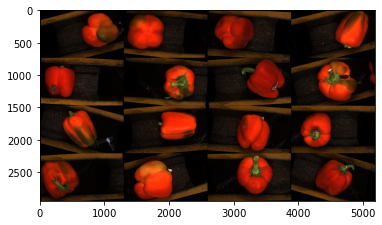

In [7]:
def matplotlib_imshow(img):
    plt.imshow(img.permute(2, 1, 0))
    
dataiter = iter(trainloader)
sample = dataiter.next()
images = sample['image']
# create grid of images
img_grid = torchvision.utils.make_grid(images, nrow=4)

# show images
matplotlib_imshow(img_grid)

In [8]:
sample['label'].shape

torch.Size([16, 7])

## Using ResNet50; a good compromise

In [9]:
model = torchvision.models.resnet50(pretrained=True)

## Check which layers need to be changed

In [10]:
# model
#o=model(images)
#print(o.shape)


In [11]:
for param in model.parameters():
    param.requires_grad = False
    
# Now replace the last layer which by default requires the gradient    
model.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=noutputs),
                         nn.Sigmoid())

net = model.to(device)

In [12]:
o=net(images.to(device))
print(o.shape)

torch.Size([16, 7])


## Multi-label classification is treated as multiple single binary classification task for each label

In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=.0001)

In [14]:
def get_accuracy(net, loader):

    correct = 0
    total = 0

    ['Wrinkeled', 'Broken stamp', 'Hole', 'Cut', 'Bounce', 'Sun burn', 'Trip']
    threshold_dict = {'Wrinkeled': 0.5, 
                      'Cut': 0.5, 
                      'Bounce': 0.5, 
                      'Hole': 0.5,
                      'Sun burn': 0.5, 
                      'Broken stamp': 0.5, 
                      'Trip': 0.5}

    threshold_tensor = torch.tensor(list(threshold_dict.values())).to(device)
    with torch.no_grad():
        for data in loader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = net(images)
            predicted = outputs>threshold_tensor
            total += torch.numel(outputs)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

## Training Loop

In [ ]:
for epoch in range(nepochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        
    if epoch % 20 == 0:
        print('Epoch: %d --- loss: %.6f' % (epoch + 1, running_loss / len(trainloader)))
        val_acc = get_accuracy(net, valloader)
        train_acc = get_accuracy(net, trainloader)
    
        writer.add_scalar('training loss',
                            running_loss / len(trainloader),
                            epoch)
        writer.add_scalar('Training acc', train_acc, epoch)
        writer.add_scalar('Validation acc', val_acc, epoch)
        
print('Finished Training')

Epoch: 1 --- loss: 0.376480
Epoch: 21 --- loss: 0.316099
Epoch: 41 --- loss: 0.296706
Epoch: 61 --- loss: 0.286317
Epoch: 81 --- loss: 0.279001
Epoch: 101 --- loss: 0.269965
Epoch: 121 --- loss: 0.263103
Epoch: 141 --- loss: 0.260024
Epoch: 161 --- loss: 0.256071
Epoch: 181 --- loss: 0.250714
Epoch: 201 --- loss: 0.245512
Epoch: 221 --- loss: 0.243390
Epoch: 241 --- loss: 0.242218
Epoch: 261 --- loss: 0.236298
Epoch: 281 --- loss: 0.235730
Epoch: 301 --- loss: 0.233487
Epoch: 321 --- loss: 0.233063
Epoch: 341 --- loss: 0.229655
Epoch: 361 --- loss: 0.229039
Epoch: 381 --- loss: 0.230514
Epoch: 401 --- loss: 0.225534
Epoch: 421 --- loss: 0.226231
Epoch: 441 --- loss: 0.222490
Epoch: 461 --- loss: 0.222965
Epoch: 481 --- loss: 0.221155


In [ ]:
PATH = model_filename
torch.save(net.state_dict(), PATH)

In [ ]:
print('Accuracy of the network: %d %%' % get_accuracy(valloader))